# Explosive Mode Analysis of Isothermal vs Adiabatic Reactors

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- Simulating the ignition of a hypothetical isothermal reactor
- How to compute quantities relevant to explosive mode analysis
- Comparing isothermal (chemical feedback) vs adiabatic (thermal _and_ chemical feedback) ignition

## Introduction

In this demonstration, we'll take a brief look at chemical explosive mode analsis (CEMA) of simple hydrogen-air reactors. One reactor is a typical isobaric, adiabatic system, while the other is a hypothetical isothermal reactor - heat release is instantaneously dissipated and the mixture is kept at its initial temperature. The isothermal reactor will still "ignite" in the sense that self-catalyzing chain reactions will occur as a pool of radical species is built up. While this chemical feedback loop will remain, the thermal feedback, wherein heat release further accelerates combustion, is removed.

In [4]:
from spitfire import ChemicalMechanismSpec, HomogeneousReactor, explosive_mode_analysis
import matplotlib.pyplot as plt
import numpy as np

mech = ChemicalMechanismSpec('h2-burke.yaml', 'h2-burke')

air = mech.stream(stp_air=True)
fuel = mech.stream('X', 'H2:1')

mix = mech.mix_for_equivalence_ratio(1.0, fuel, air)
mix.TP = 1000., 101325.

Now simply set up the two reactors and integrate them a bit in time.

In [5]:
isothermal_reactor = HomogeneousReactor(mech, mix, 'isobaric', 'isothermal', 'closed')
adiabatic_reactor = HomogeneousReactor(mech, mix, 'isobaric', 'adiabatic', 'closed')

iso = isothermal_reactor.integrate_to_time(1.e-3)
adi = adiabatic_reactor.integrate_to_time(1.e-3)

## Chemical Explosive Mode Analysis

CEMA is a technique of assessing chemical behavior through eigenvalue/eigenvector analysis of the chemical source Jacobian matrix. Feedback cycles such as chemical and thermal runaway in ignition show up as eigenvalues with positive real part. CEMA is fundamentally limited to locally linear analysis, which complicates multidimensional problems where molecular mixing couples nontrivially with explosive chemical modes. However, for homogeneous reactor models, CEMA is ideal.

Spitfire makes it easy to compute some CEMA-related quantities. Simply import the `explosive_mode_analysis` method and provide it with a mechanism and a `Library` object from a reactor, flamelet, tabulated chemistry builder, or your own creation.

The fundamental quantity in CEMA is the "explosive eigenvalue," which is the largest real part of nonzero eigenvalues. Determining what counts as a nonzero value is an unresolved issue. Zero eigenvalues exist due to elemental conservation, and mass/energy conservation for closed reactors, and a problem is certainty of the eigenvalues (number of valid digits) because the matrix is singular. Numerical eigensolvers will not yield many signficiant digits. Spitfire simply calls any eigenvalue of magnitude less than $10^{-4}$ a zero. A more precise definition would be great for CEMA research but seems unlikely.

In addition to the explosive eigenvalue, you can also request "explosion indices," which are normalized components of species and temperature on the eigenvector corresponding to the explosive mode. Further, "participation indices" are those components mapped back through stoichiometry to elementary chemical reactions.

A final note: certain fuels such as DME and biodiesel, discussed in another reactor demonstration, yield two explosive eigenvalues when low-temperature ignition pathways are active. Spitfire can easily incorporate this secondary mode and its explosion/participation indices - just set a few extra arguments. Hydrogen does not admit a significant secondary explosive mode, so we turn it off here (it is off by default).

In [6]:
iso = explosive_mode_analysis(mech, iso, 'isobaric', 'isothermal',
                              compute_explosion_indices=True,
                              compute_participation_indices=True,
                              include_secondary_mode=False)

adi = explosive_mode_analysis(mech, adi, 'isobaric', 'adiabatic',
                              compute_explosion_indices=True,
                              compute_participation_indices=True,
                              include_secondary_mode=False)

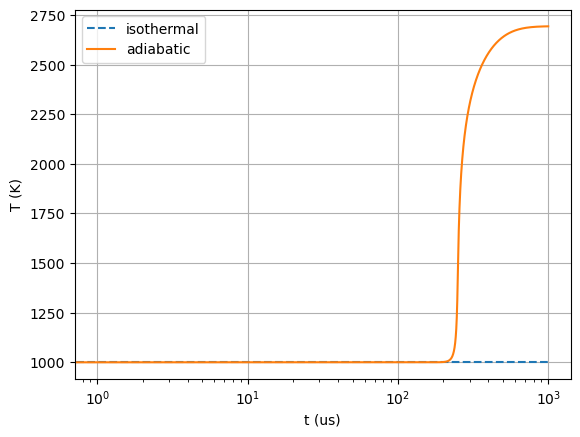

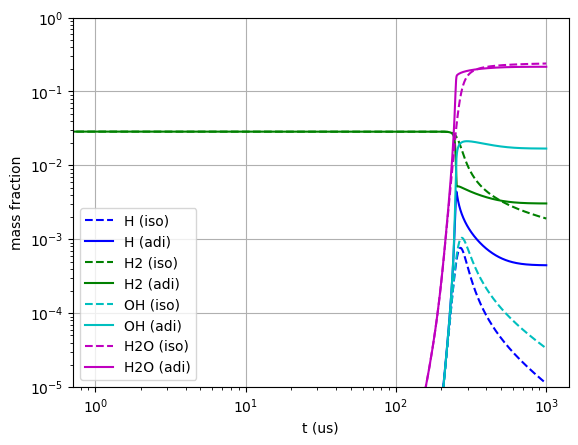

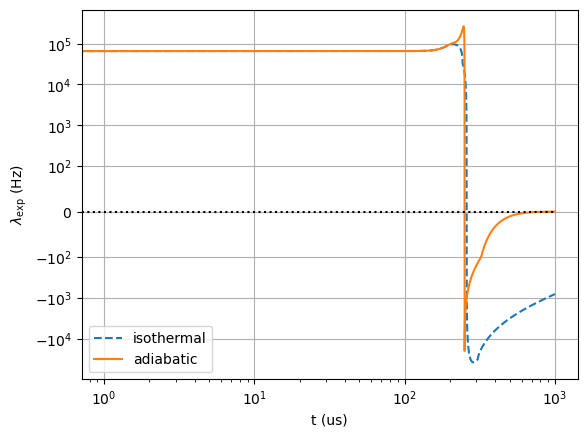

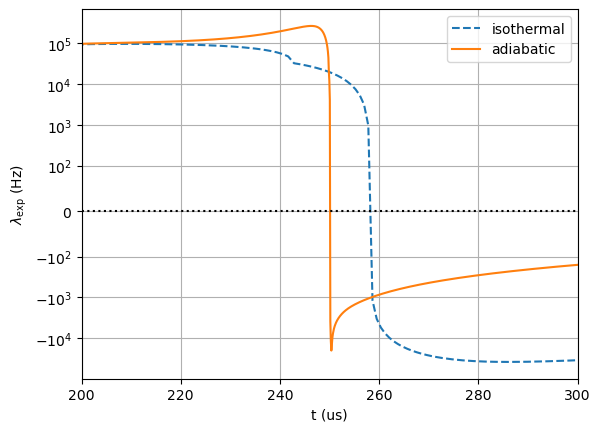

In [9]:
plt.semilogx(iso.time_values * 1.e6, iso['temperature'], '--', label=f'isothermal')
plt.semilogx(adi.time_values * 1.e6, adi['temperature'], '-', label=f'adiabatic')
plt.ylabel('T (K)')
plt.xlabel('t (us)')
plt.legend()
plt.grid()
plt.show()

for s, c in [('H', 'b'), ('H2', 'g'), ('OH', 'c'), ('H2O', 'm')]:
    plt.loglog(iso.time_values * 1.e6, iso[f'mass fraction {s}'], c + '--', label=f'{s} (iso)')
    plt.loglog(adi.time_values * 1.e6, adi[f'mass fraction {s}'], c + '-', label=f'{s} (adi)')
plt.ylabel('mass fraction')
plt.xlabel('t (us)')
plt.legend()
plt.grid()
plt.ylim([1e-5, 1e0])
plt.show()

plt.semilogx(iso.time_values * 1.e6, iso['cema-lexp1'], '--', label='isothermal')
plt.semilogx(adi.time_values * 1.e6, adi['cema-lexp1'], '-', label='adiabatic')
plt.semilogx(iso.time_values * 1.e6, np.zeros_like(iso.time_values), 'k:')
plt.ylabel('$\\lambda_{\\rm exp}$ (Hz)')
plt.xlabel('t (us)')
plt.yscale('symlog', linthresh=1e2)
plt.legend()
plt.grid()
plt.show()

plt.semilogy(iso.time_values * 1.e6, iso['cema-lexp1'], '--', label='isothermal')
plt.semilogy(adi.time_values * 1.e6, adi['cema-lexp1'], '-', label='adiabatic')
plt.semilogy(iso.time_values * 1.e6, np.zeros_like(iso.time_values), 'k:')
plt.ylabel('$\\lambda_{\\rm exp}$ (Hz)')
plt.xlabel('t (us)')
plt.yscale('symlog', linthresh=1e2)
plt.xlim([2e2, 3e2])
plt.legend()
plt.grid()
plt.show()



These preliminary results show a surprising degree of similarity between the adiabatic and isothermal reactors. The reason is fairly clear though - the induction phase of the adiabatic reactor is entirely isothermal! This isn't always the case - larger fuel breakdown during induction is endothermic - but for hydrogen the only real difference shows up when the temperature starts to rise. The final figure above shows the explosive eigenvalue of the adiabatic reactor rapidly rising to a peak while the isothermal eigenvalue dies out. Both see the eigenvalue transition to a negative value, indicating the approach to a stable equilibrium state, although the adiabatic reactor, due to its much higher temperature, equilibrates much faster.

Next we look at the explosion and participation indices.

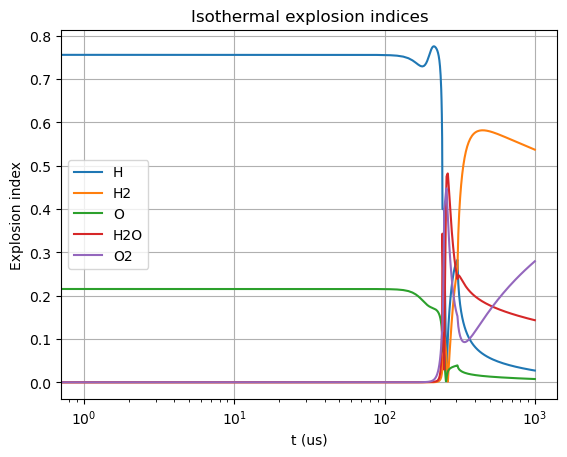

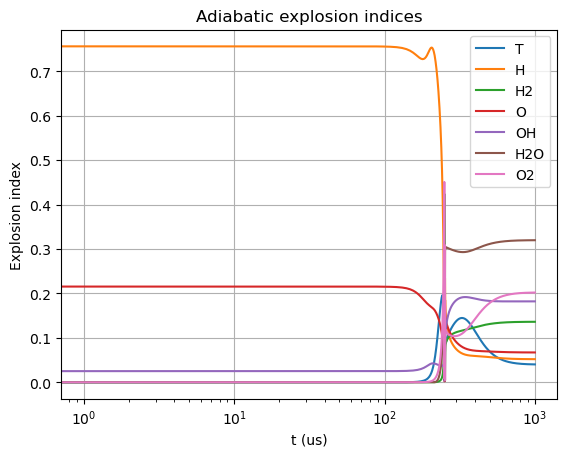

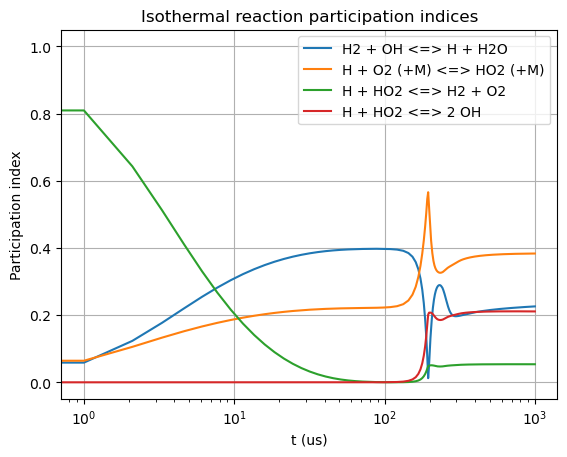

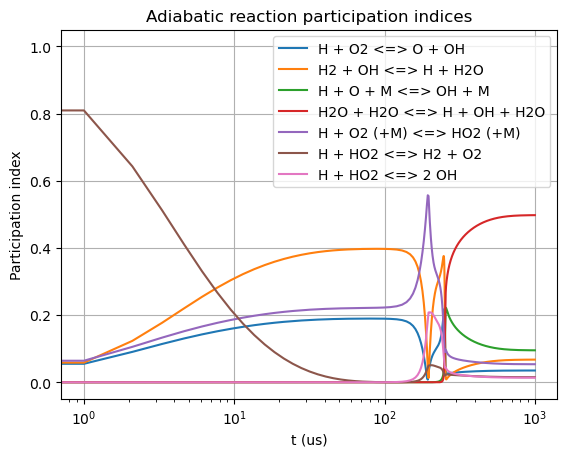

In [11]:
for name in ['T'] + mech.species_names[:-1]:
    ei = iso['cema-ei1 ' + name]
    if np.max(ei) > 0.1:
        plt.semilogx(iso.time_values * 1.e6, ei, label=name)
plt.ylabel('Explosion index')
plt.xlabel('t (us)')
plt.legend()
plt.grid()
plt.title('Isothermal explosion indices')
plt.show()

for name in ['T'] + mech.species_names[:-1]:
    ei = adi['cema-ei1 ' + name]
    if np.max(ei) > 0.1:
        plt.semilogx(adi.time_values * 1.e6, ei, label=name)
plt.ylabel('Explosion index')
plt.xlabel('t (us)')
plt.legend()
plt.grid()
plt.title('Adiabatic explosion indices')
plt.show()


for i in range(mech.n_reactions):
    pi = iso['cema-pi1 ' + str(i)]
    if np.max(pi) > 0.2:
        plt.semilogx(iso.time_values * 1.e6, pi,
                     label=mech.gas.reaction(i).equation)
plt.ylabel('Participation index')
plt.xlabel('t (us)')
plt.legend()
plt.grid()
plt.title('Isothermal reaction participation indices')
plt.show()

for i in range(mech.n_reactions):
    pi = adi['cema-pi1 ' + str(i)]
    if np.max(pi) > 0.2:
        plt.semilogx(adi.time_values * 1.e6, pi,
                     label=mech.gas.reaction(i).equation)
plt.ylabel('Participation index')
plt.xlabel('t (us)')
plt.legend()
plt.grid()
plt.title('Adiabatic reaction participation indices')
plt.show()

The index analysis shows the relevant species and the importance of temperature in the explosive mode. Both reactors see the hydrogen radical playing the largest role during induction, due to its role as the leading chain carrier in chemical runaway.
When ignition peaks, thermal runaway is indicated by the role of temperature in the adiabatic reactor's explosive mode.
If you have interest in chain reaction mechanisms, CK Law's book _Combustion Physics_ has an excellent description of hydrogen ignition that would go nicely with this demonstration.
You might wonder why the results appear to contain "noise" as if experiments - as suggested above, eigen-analysis of a singular matrix is not numerically precise and jumps as seen above where the eigenvalue transitions are expected.


## Conclusions

This notebook shows how Spitfire enables chemical explosive mode analysis, and showed some interesting comparisons between adiabatic and isothermal reactor models.